In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle
import matplotlib.colors as mcolors

url = "https://docs.google.com/spreadsheets/d/1E-Nbbt6EkaAVcKcs3whBEkRzMUGKYXN8Fb-ZRXZzVDE/export?format=csv"
df1_end = 42
df2_end = 56

colors = {
 "PrIM": '#fff191',
 "PrIMC": '#ffd100',
 'PS': '#ff8100',
 "SimplePIM": '#3daa8a',
 "ATiM": '#3b88fd'
}
hatches = {
    "Kernel": "",
    "H2D": r"////////",
    "After": r"\\\\\\\\",
    "After Kernel": r"\\\\\\\\",
}
plt.rcParams.update({'font.family':'Arial'})

# Retrieve new data and preprocess into a couple of DFs
df = pd.read_csv(url)
# Retrieve specific sheet from Google Sheets

df = df.fillna(0)
df.columns = df.iloc[0]
df1 = df.iloc[1:df1_end - 1, :17].reset_index(drop=True)
df2 = df.iloc[df1_end - 1:df2_end - 1, :17].reset_index(drop=True)

df3 = df1.copy()
# df3.iloc[:, 2:] = df3.iloc[:, 2:].astype(float).div(df3.iloc[:, 2:5].astype(float).sum(axis=1), axis=0) # norm with prim
df3.iloc[:, 2:] = df3.iloc[:, 2:].astype(float).div(df3.iloc[:, 2:5].astype(float).sum(axis=1), axis=0)

df4 = df2.copy()
df4.iloc[:, 2:] = df4.iloc[:, 2:].astype(float).div(df4.iloc[:, 2:5].astype(float).sum(axis=1), axis=0)

url_with_sheet = f"{url}&gid=1630625191"
df_opt = pd.read_csv(url_with_sheet)
df_opt = df_opt.fillna(0)
df_opt.header = df_opt.iloc[0]
df_opt = df_opt.iloc[:, 1:9].reset_index(drop=False)

def adjust_color(color, factor=0.7):
    if isinstance(color, list):
        return [adjust_color(c, factor) for c in color]
    rgb = mcolors.to_rgb(color)
    adjusted_rgb = tuple([c * factor for c in rgb])
    return adjusted_rgb

print(df_opt)

    index     N      M      K      PrIM         O0        O1        O2   
0       0  64.0   26.0  256.0  0.800040   2.497105  0.853492  0.852334  \
1       1  64.0   69.0  256.0  0.955857   4.496810  1.192778  1.190924   
2       2  64.0  109.0  256.0  0.829024   2.797715  0.874797  0.875378   
3       3  64.0  126.0  256.0  0.832616   2.796170  0.875053  0.874181   
4       4  64.0  153.0  256.0  0.971709   4.514139  1.199511  1.199103   
..    ...   ...    ...    ...       ...        ...       ...       ...   
94     94   0.0    8.0    0.0  0.908300  12.337136  1.108326  0.756122   
95     95   0.0    9.0    0.0  1.004500  13.820550  1.397118  0.846765   
96     96   0.0   10.0    0.0  1.091900  15.282098  1.533301  0.922527   
97     97   0.0    0.0    0.0  0.000000   0.000000  0.000000  0.000000   
98     98   0.0    0.0    0.0  0.000000   0.000000  0.000000  0.000000   

          O4  
0   0.753312  
1   1.048143  
2   0.785790  
3   0.787031  
4   1.060382  
..       ...  
94  0.

/var/folders/nr/j1w6g36n6sx5b_9fgx_xy39r0000gn/T/ipykernel_98257/2219248458.py:46: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_opt.header = df_opt.iloc[0]


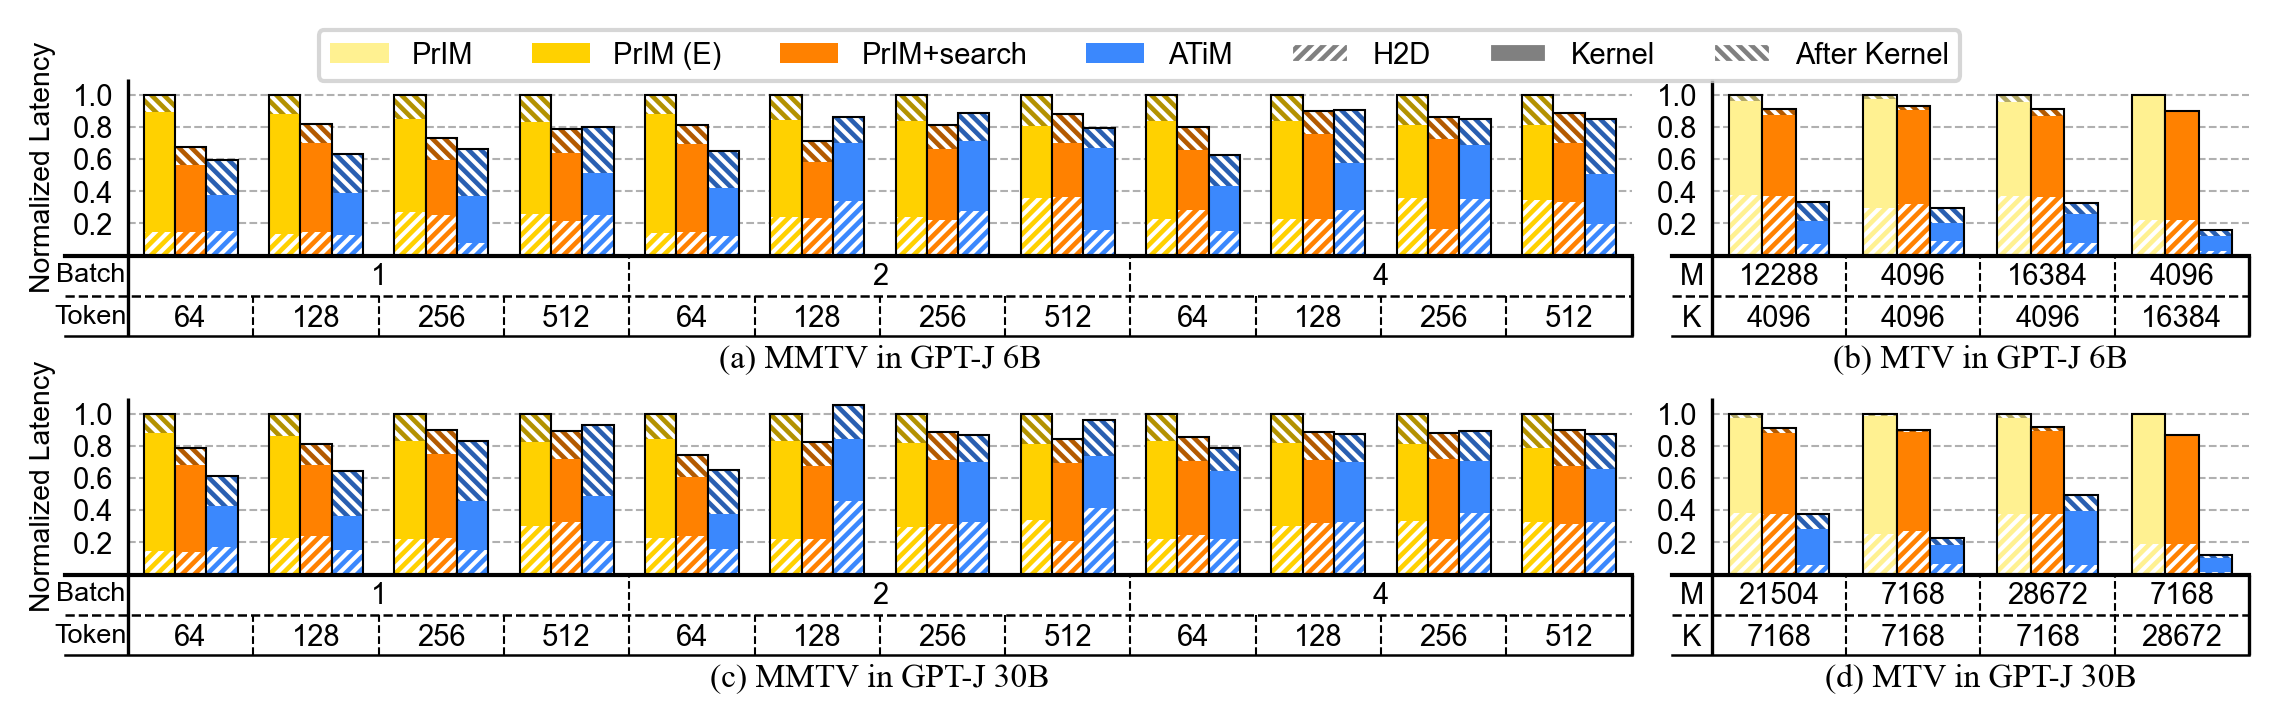

In [192]:
threshold = 3.2 # 상위 12행
interval = 0.5
width_mmtv = 14
width_mtv = 5
height = 2.2
height_table = 0.5
bar_width = 0.25
fontsize = 7
latency_label = "Latency (ms)"

# Define a function to create the plot
def create_plot(ax, df_subset, width, threshold, interval=0.5, bar_width=0.25, colors=colors, hatches=hatches, caption="", batch_unit=16):
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_capstyle("butt")
    ax.spines['bottom'].set_visible(False)
    x = np.arange(len(df_subset['Workload']))
    ax.set_xlim(-0.5, len(x) - 0.5)
    ax.set_ylim(0, threshold)
    ax.yaxis.grid(True, linestyle='--', zorder=0, linewidth=0.5)
    y_ticks = np.arange(0, threshold, interval)
    ax.tick_params(axis='both', which='both', direction='in', length=0)
    ax.set_yticks(y_ticks)
    ax.set_yticklabels([f"{tick:.1f}" if tick != 0 else "" for tick in y_ticks], fontsize=fontsize)
    ax.set_xticklabels([])
    ax.set_xticks(x)

    def plot_bars(ax, x, width, df, label_prefix, color, hatch):
        h2d_val = df[f'{label_prefix}-H2D'].astype(float)
        kernel_val = df[f'{label_prefix}-Kernel'].astype(float)
        after_val = df[f'{label_prefix}-After'].astype(float)
        pos = x
        ax.bar(pos, h2d_val, bar_width,
               linewidth=0, zorder=2,label=f'{label_prefix}-H2D',
               color=color, edgecolor="white", hatch=hatch['H2D'])
        ax.bar(pos, kernel_val, bar_width, bottom=h2d_val,
               linewidth=0, zorder=2, label=f'{label_prefix}-Kernel',
               color=color, hatch=hatch['Kernel'])
        adjusted_color = adjust_color(color)
        ax.bar(pos, after_val, bar_width, bottom=h2d_val + kernel_val,
               linewidth=0, zorder=2, label=f'{label_prefix}-After',
               color=adjusted_color, edgecolor="white", hatch=hatch['After'])
        ax.bar(pos, h2d_val + kernel_val + after_val, bar_width,
               linewidth=0.5, zorder=2, edgecolor='black', fill=False)
        total_height = (h2d_val + kernel_val + after_val).tolist()
        for i in range(len(x)):
            if total_height[i] > threshold:
                ax.text(x[i], threshold, f'{total_height[i]:.2f}', ha='center', va='bottom', fontsize=fontsize)

    is_mmtv = "mmtv" in df_subset["Workload"].values[0]

    prim_label = "PrIMC" if is_mmtv else "PrIM"

    plot_bars(ax, x - bar_width, width, df_subset, "PrIM", colors[prim_label], hatches)
    plot_bars(ax, x, width, df_subset, 'PS', colors['PS'], hatches)
    plot_bars(ax, x + bar_width, width, df_subset, 'ATiM', colors['ATiM'], hatches)

    # plot_bars(ax, x - bar_width, width, df_subset, 'PrIM', colors['PrIM'], hatches)
    # plot_bars(ax, x, width, df_subset, 'PST', colors['SimplePIM'], hatches)
    # plot_bars(ax, x + bar_width, width, df_subset, 'ATiM', colors['ATiM'], hatches)

    if is_mmtv:
        ax.set_ylabel(latency_label, fontsize=fontsize - 0.2)

    workloads = df_subset['Workload'].str.split(' ', expand=True)

    ylabel_offset = 0.04
    ylabel_interval = 0.24

    if is_mmtv:
        B_labels = (workloads[1].astype(int) // batch_unit).astype(str)
        M_labels = workloads[2]
        ax.text(-0.5 - 0.3, -ylabel_offset, 'Batch', ha='center', va='top', transform=ax.get_xaxis_transform(), fontsize=fontsize - 0.5)
        ax.text(-0.5 - 0.3, -ylabel_offset - ylabel_interval, 'Token', ha='center', va='top', transform=ax.get_xaxis_transform(), fontsize=fontsize - 0.5)
        for i, label in enumerate(B_labels):
            if i % 4 == 1:
                ax.text((x[i] + x[i+1]) / 2, -ylabel_offset, label, ha='center', va='top', transform=ax.get_xaxis_transform(), fontsize=fontsize)
        for i, label in enumerate(M_labels):
            ax.text(x[i], -ylabel_offset - ylabel_interval, label, ha='center', va='top', transform=ax.get_xaxis_transform(), fontsize=fontsize)
        for i in range(len(x) - 1):
            yy = ax.axvline((x[i] + x[i+1]) / 2, color='black', ymin=(-height_table / height) * 2, ymax=0.01 if x[i] % 4 == 3 else (-height_table / height), lw=0.5, linestyle="--")
            yy.set_clip_on(False)
    else:
        ax.text(-0.5 - 0.15, -ylabel_offset, 'M', ha='center', va='top', transform=ax.get_xaxis_transform(), fontsize=fontsize)
        ax.text(-0.5 - 0.15, -ylabel_offset - ylabel_interval, 'K', ha='center', va='top', transform=ax.get_xaxis_transform(), fontsize=fontsize)
        M_labels = workloads[1]
        K_labels = workloads[3]
        for i, label in enumerate(M_labels):
            ax.text(x[i], -ylabel_offset, label, ha='center', va='top', transform=ax.get_xaxis_transform(), fontsize=fontsize)
        for i, label in enumerate(K_labels):
            ax.text(x[i], -ylabel_offset - ylabel_interval, label, ha='center', va='top', transform=ax.get_xaxis_transform(), fontsize=fontsize)
        for i in range(len(x) - 1):
            yy = ax.axvline((x[i] + x[i+1]) / 2, color='black', ymin=-(height_table / height) * 2, ymax=0, lw=0.5, linestyle="--")
            yy.set_clip_on(False)

    rpt = threshold * height_table / height
    xmin = (-0.5 if is_mmtv else -0.3) / len(x)
    h0 = ax.axhline(-0, color='black',xmin=xmin, lw=1)
    hl = ax.axhline(-rpt, color='black', lw=0.6, xmin=xmin, linestyle="--")
    h2 = ax.axhline(-rpt * 2, color='black',xmin=xmin, lw=0.6)

    h0.set_clip_on(False)
    hl.set_clip_on(False)
    h2.set_clip_on(False)

    ax.spines['left'].set_bounds(-rpt * 2, threshold)
    ax.spines['left'].set_capstyle("butt")
    ax.spines['left'].set_clip_on(False)
    ax.spines['right'].set_bounds(-rpt * 2, 0)
    ax.spines['right'].set_capstyle("butt")
    ax.spines['right'].set_clip_on(False)

    # caption
    if caption:
        ax.text(0.5, -0.5, caption, ha='center', va='top',
                transform=ax.transAxes, fontsize=8, fontname='Times New Roman')

def non_normalized():
    global latency_label
    latency_label = "Latency (ms)"
    fig = plt.figure(figsize=(7.48, (height * 2 + 1)/ 2.54), dpi=300, constrained_layout=True)
    gs = gridspec.GridSpec(2, 2, width_ratios=[width_mmtv, width_mtv], wspace=0.03, hspace=0.03, figure=fig)
    axs = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[1, 0]), fig.add_subplot(gs[0, 1]), fig.add_subplot(gs[1, 1])]

    create_plot(axs[0], df1.iloc[:12], width_mmtv, threshold=3.1, interval=0.5,
                bar_width=bar_width, colors=colors, hatches=hatches, caption="(a) MMTV in GPT-J 6B", batch_unit=16)
    create_plot(axs[1], df1.iloc[16:28], width_mmtv, threshold=4.5, interval=0.5,
                bar_width=bar_width, colors=colors, hatches=hatches, caption="(c) MMTV in GPT-J 30B", batch_unit=28)
    create_plot(axs[2], df1.iloc[32:36], width_mtv, threshold=12, interval=2,
                bar_width=bar_width, colors=colors, hatches=hatches, caption="(b) MTV in GPT-J 6B")
    create_plot(axs[3], df1.iloc[36:40], width_mtv, threshold=30, interval=5,
                bar_width=bar_width, colors=colors, hatches=hatches, caption="(d) MTV in GPT-J 30B")

    handles = [
        Rectangle((0, 0), 1, 1, facecolor=colors["PrIM"], label='PrIM'),
        Rectangle((0, 0), 1, 1, facecolor=colors["PrIMC"], label='PrIM (E)'),
        Rectangle((0, 0), 1, 1, facecolor=colors["PS"], label='PrIM+search'),
        Rectangle((0, 0), 1, 1, facecolor=colors["ATiM"], label='ATiM'),
        Rectangle((0, 0), 1, 1, facecolor='gray', label='H2D', edgecolor="white",hatch=hatches["H2D"]),
        Rectangle((0, 0), 1, 1, facecolor='gray', label='Kernel', edgecolor="white"),
        Rectangle((0, 0), 1, 1, facecolor='gray', label='After Kernel', edgecolor="white",hatch=hatches["After"])
    ]

    # handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles=handles, loc='upper center', ncol=7, fontsize=fontsize, bbox_to_anchor=(0.5, 1.08))
    fig.savefig(f"/Users/kdk/Library/CloudStorage/OneDrive-SNU/ATiM Eurosys2025/gpt_experiment.pdf", format="pdf", dpi=300, bbox_inches="tight")
# fig.savefig(f"main.pdf", format="pdf", dpi=300, bbox_inches="tight")


    # normalized
def normalized():
    global latency_label
    latency_label = "Normalized Latency"
    fig = plt.figure(figsize=(7.48, (height * 2 + 1)/ 2.54), dpi=300, constrained_layout=True)
    gs = gridspec.GridSpec(2, 2, width_ratios=[width_mmtv, width_mtv], wspace=0.02, hspace=0.03, figure=fig)
    axs = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[1, 0]), fig.add_subplot(gs[0, 1]), fig.add_subplot(gs[1, 1])]

    create_plot(axs[0], df3.iloc[:12], width_mmtv, threshold=1.1, interval=0.2,
                bar_width=bar_width, colors=colors, hatches=hatches, caption="(a) MMTV in GPT-J 6B", batch_unit=16)
    create_plot(axs[1], df3.iloc[16:28], width_mmtv, threshold=1.1, interval=0.2,
                bar_width=bar_width, colors=colors, hatches=hatches, caption="(c) MMTV in GPT-J 30B", batch_unit=28)
    create_plot(axs[2], df3.iloc[32:36], width_mtv, threshold=1.1, interval=0.2,
                bar_width=bar_width, colors=colors, hatches=hatches, caption="(b) MTV in GPT-J 6B")
    create_plot(axs[3], df3.iloc[36:40], width_mtv, threshold=1.1, interval=0.2,
                bar_width=bar_width, colors=colors, hatches=hatches, caption="(d) MTV in GPT-J 30B")


    fig.legend(handles=handles, loc='upper center', ncol=7, fontsize=fontsize, bbox_to_anchor=(0.5, 1.08))
    fig.savefig(f"/Users/kdk/Library/CloudStorage/OneDrive-SNU/ATiM Eurosys2025/gpt_experiment_normalized.pdf", format="pdf", dpi=300, bbox_inches="tight")

normalized()

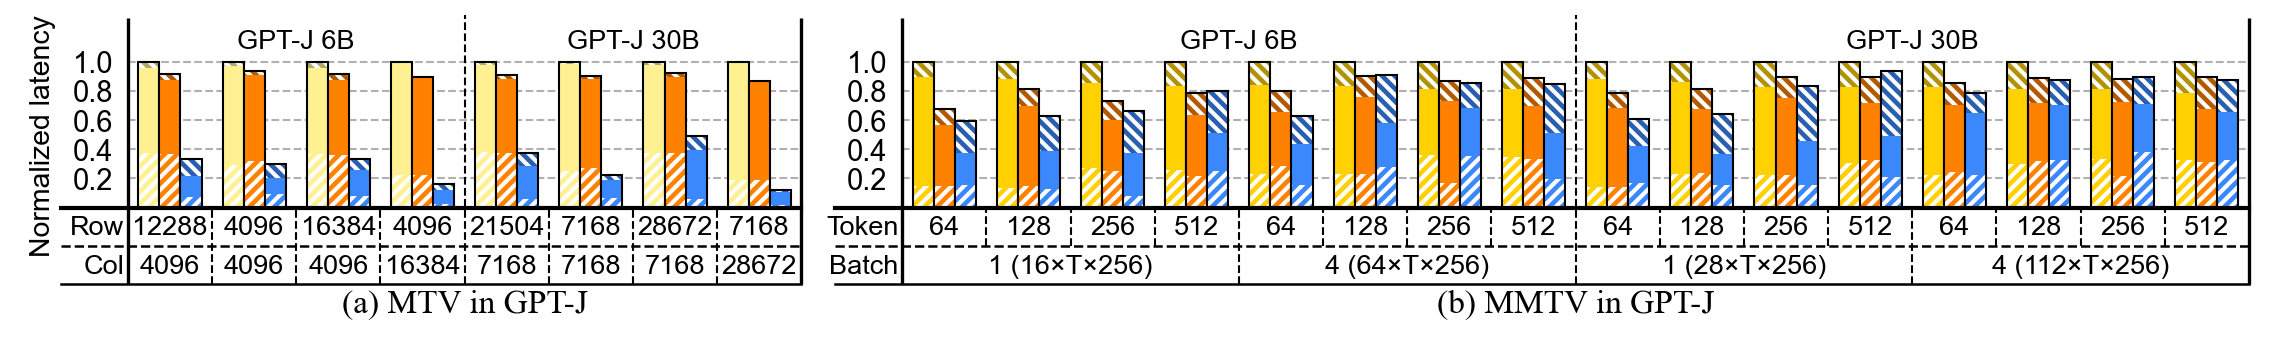

In [19]:
threshold = 3.2 # 상위 12행
interval = 0.5
width_mmtv = 10
width_mtv = 5
height = 2.1
height_table = 0.5
bar_width = 0.25
fontsize = 7
latency_label = "Latency (ms)"
ylabel_offset = 0.05
ylabel_interval = 0.24
y_params = 1.11

# Define a function to create the plot
def create_plot(ax, df_subset, width, threshold, interval=0.5, bar_width=0.25, colors=colors, hatches=hatches, caption="", batch_unit=16):
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_capstyle("butt")
    ax.spines['bottom'].set_visible(False)
    x = np.arange(len(df_subset['Workload']))
    ax.set_xlim(-0.5, len(x) - 0.5)
    ax.set_ylim(0, threshold)
    ax.yaxis.grid(True, linestyle='--', zorder=0, linewidth=0.5)
    y_ticks = np.arange(0, threshold, interval)
    ax.tick_params(axis='both', which='both', direction='in', length=0)
    ax.set_yticks(y_ticks)
    ax.set_yticklabels([f"{tick:.1f}" if tick != 0 else "" for tick in y_ticks], fontsize=fontsize)
    ax.set_xticklabels([])
    ax.set_xticks(x)

    def plot_bars(ax, x, width, df, label_prefix, color, hatch):
        h2d_val = df[f'{label_prefix}-H2D'].astype(float)
        kernel_val = df[f'{label_prefix}-Kernel'].astype(float)
        after_val = df[f'{label_prefix}-After'].astype(float)
        pos = x
        common = dict(linewidth=0, zorder=2, color=color, edgecolor="white")
        ax.bar(pos, h2d_val, bar_width, label=f'{label_prefix}-H2D', hatch=hatch['H2D'], **common)
        ax.bar(pos, kernel_val, bar_width, bottom=h2d_val, label=f'{label_prefix}-Kernel', hatch=hatch['Kernel'], **common)
        adjusted_color = adjust_color(color)
        ax.bar(pos, after_val, bar_width, bottom=h2d_val + kernel_val, linewidth=0, zorder=2, label=f'{label_prefix}-After',
               color=adjusted_color, edgecolor="white", hatch=hatch['After'])
        ax.bar(pos, h2d_val + kernel_val + after_val, bar_width, linewidth=0.5, zorder=2, edgecolor='black', fill=False)
        total_height = (h2d_val + kernel_val + after_val).tolist()
        for i in range(len(x)):
            if total_height[i] > threshold:
                ax.text(x[i], threshold, f'{total_height[i]:.2f}', ha='center', va='bottom', fontsize=fontsize)

    is_mmtv = "mmtv" in df_subset["Workload"].values[0]
    prim_label = "PrIMC" if is_mmtv else "PrIM"

    plot_bars(ax, x - bar_width, width, df_subset, "PrIM", colors[prim_label], hatches)
    plot_bars(ax, x, width, df_subset, 'PS', colors['PS'], hatches)
    plot_bars(ax, x + bar_width, width, df_subset, 'ATiM', colors['ATiM'], hatches)

    if not is_mmtv:
        ax.set_ylabel(latency_label, fontsize=fontsize - 0.2)

    workloads = df_subset['Workload'].str.split(' ', expand=True)
    ypos = lambda x: -ylabel_offset - ylabel_interval * x
    cconf = dict(ha="center", va="top", transform=ax.get_xaxis_transform(), fontsize=fontsize - 0.5)
    hconf = dict(ha="right", va="top", transform=ax.get_xaxis_transform(), fontsize=fontsize - 0.5)
    #cconf_small = dict(ha="center", va="top", transform=ax.get_xaxis_transform(), fontsize=fontsize - 1)

    if is_mmtv:
        M_labels = workloads[2]
        ax.text(-0.54, ypos(0), 'Token', **hconf)
        ax.text(-0.54, ypos(1), 'Batch', **hconf)
        # ax.text(-0.54, ypos(2), 'Params', **hconf)
        for i, label in enumerate(M_labels):
            ax.text(x[i], -ylabel_offset, label, **cconf)
        for i, label in enumerate(["1 (16×T×256)", "4 (64×T×256)", "1 (28×T×256)", "4 (112×T×256)"]):
            ax.text((x[i * 4 + 1] + x[i * 4 + 2]) / 2, ypos(1), label, **cconf)
        for i, label in enumerate(["GPT-J 6B","GPT-J 30B"]):
            ax.text((x[i * 8 + 3] + x[i * 8 + 4]) / 2, y_params, label, **cconf)
        for i in range(len(x) - 1):
            ymin = (-height_table / height) * (2 if x[i] % 4 == 3 else 1)
            ymax = 1.2 if x[i] % 8 == 7 else 0.01
            yy = ax.axvline((x[i] + x[i+1]) / 2, color='black', ymin= ymin, ymax=ymax, lw=0.5, linestyle="--")
            yy.set_clip_on(False)
    else:
        ax.text(-0.54, ypos(0), 'Row', **hconf)
        ax.text(-0.54, ypos(1), 'Col', **hconf)
        # ax.text(-0.54, ypos(2), 'Params', **hconf)
        M_labels = workloads[1]
        K_labels = workloads[3]
        for i, label in enumerate(M_labels):
            ax.text(x[i], ypos(0), label, **cconf)
        for i, label in enumerate(K_labels):
            ax.text(x[i], ypos(1), label, **cconf)
        for i, label in enumerate(["GPT-J 6B", "GPT-J 30B"]):
            ax.text((x[i * 4 + 1] + x[i * 4 + 2]) / 2, y_params, label, **cconf)
        for i in range(len(x) - 1):
            ymin = (-height_table / height) * (2 if x[i] % 4 == 3 else 2)
            ymax = 1.2 if x[i] % 4 == 3 else 0.01
            yy = ax.axvline((x[i] + x[i+1]) / 2, color='black', ymin= ymin, ymax=ymax, lw=0.5, linestyle="--")
            yy.set_clip_on(False)

    rpt = threshold * height_table / height
    xmin = (-0.8 if is_mmtv else -0.8) / len(x)
    h0 = ax.axhline(-0, color='black',xmin=xmin, lw=1)
    hl = ax.axhline(-rpt, color='black', lw=0.6, xmin=xmin, linestyle="--")
    h2 = ax.axhline(-rpt * 2, color='black',xmin=xmin, lw=0.6)
    # h3 = ax.axhline(-rpt * 3, color='black',xmin=xmin, lw=0.6)

    h0.set_clip_on(False)
    hl.set_clip_on(False)
    h2.set_clip_on(False)
    # h3.set_clip_on(False)

    ax.spines['left'].set_bounds(-rpt * 2, threshold + 0.2)
    ax.spines['left'].set_capstyle("butt")
    ax.spines['left'].set_clip_on(False)
    ax.spines['right'].set_bounds(-rpt * 2, threshold + 0.2)
    ax.spines['right'].set_capstyle("butt")
    ax.spines['right'].set_clip_on(False)

    # caption
    if caption:
        ax.text(0.5, -0.5, caption, ha='center', va='top',
                transform=ax.transAxes, fontsize=8, fontname='Times New Roman')

handles = [
    Rectangle((0, 0), 1, 1, facecolor=colors["PrIM"], label='PrIM'),
    Rectangle((0, 0), 1, 1, facecolor=colors["PrIMC"], label='PrIM (E)'),
    Rectangle((0, 0), 1, 1, facecolor=colors["PS"], label='PrIM+search'),
    Rectangle((0, 0), 1, 1, facecolor=colors["ATiM"], label='ATiM'),
    Rectangle((0, 0), 1, 1, facecolor='gray', label='H2D', edgecolor="white",hatch=hatches["H2D"]),
    Rectangle((0, 0), 1, 1, facecolor='gray', label='Kernel', edgecolor="white"),
    Rectangle((0, 0), 1, 1, facecolor='gray', label='After Kernel', edgecolor="white",hatch=hatches["After"])
]

def normalized():
    global latency_label
    latency_label = "Normalized Latency"
    fig = plt.figure(figsize=(7.48, (height + 0.5)/ 2.54), dpi=300, constrained_layout=True)
    gs = gridspec.GridSpec(1, 4, width_ratios=[width_mmtv, width_mmtv, width_mtv, width_mtv], wspace=0.02, hspace=0.03, figure=fig)
    # axs = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[1, 0]), fig.add_subplot(gs[0, 1]), fig.add_subplot(gs[1, 1])]
    axs = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1]), fig.add_subplot(gs[0, 2]), fig.add_subplot(gs[0, 3])]

    create_plot(axs[0], pd.concat([df3.iloc[:4], df3.iloc[8:12]]), width_mmtv, threshold=1.1, interval=0.2,
                bar_width=bar_width, colors=colors, hatches=hatches, caption="(a) MMTV in GPT-J 6B", batch_unit=16)
    create_plot(axs[1], pd.concat([df3.iloc[16:20], df3.iloc[24:28]]), width_mmtv, threshold=1.1, interval=0.2,
                bar_width=bar_width, colors=colors, hatches=hatches, caption="(c) MMTV in GPT-J 30B", batch_unit=28)
    create_plot(axs[2], df3.iloc[32:36], width_mtv, threshold=1.1, interval=0.2,
                bar_width=bar_width, colors=colors, hatches=hatches, caption="(b) MTV in GPT-J 6B")
    create_plot(axs[3], df3.iloc[36:40], width_mtv, threshold=1.1, interval=0.2,
                bar_width=bar_width, colors=colors, hatches=hatches, caption="(d) MTV in GPT-J 30B")


    fig.legend(handles=handles, loc='upper center', ncol=7, fontsize=fontsize, bbox_to_anchor=(0.5, 1.08))
    fig.savefig(f"/Users/kdk/Library/CloudStorage/OneDrive-SNU/ATiM Eurosys2025/gpt_experiment_normalized.pdf", format="pdf", dpi=300, bbox_inches="tight")

def normalized_combined():
    global latency_label
    latency_label = "Normalized latency  "
    fig = plt.figure(figsize=(7.48, (height + 0.5) / 2.54), dpi=300, constrained_layout=True)
    gs = gridspec.GridSpec(1, 2, width_ratios=[width_mtv, width_mmtv], wspace=0.02, hspace=0.03, figure=fig)
    axs = [fig.add_subplot(gs[0, 1]), fig.add_subplot(gs[0, 0])]

    mtv_combined_data = pd.concat([df3.iloc[32:36], df3.iloc[36:40]])
    create_plot(axs[1], mtv_combined_data, width_mtv, threshold=1.1, interval=0.2,
                bar_width=bar_width, colors=colors, hatches=hatches, caption="(a) MTV in GPT-J")
    mmtv_combined_data = pd.concat([df3.iloc[:4], df3.iloc[8:12], df3.iloc[16:20], df3.iloc[24:28]])
    create_plot(axs[0], mmtv_combined_data, width_mmtv, threshold=1.1, interval=0.2,
                bar_width=bar_width, colors=colors, hatches=hatches, caption="(b) MMTV in GPT-J")


    # fig.legend(handles=handles, loc='upper center', ncol=7, fontsize=fontsize, bbox_to_anchor=(0.5, 1.17))
    fig.savefig(f"/Users/kdk/Library/CloudStorage/OneDrive-SNU/ATiM Eurosys2025/gpt_experiment_normalized_combined.pdf",
                format="pdf", dpi=300, bbox_inches="tight")

normalized_combined()




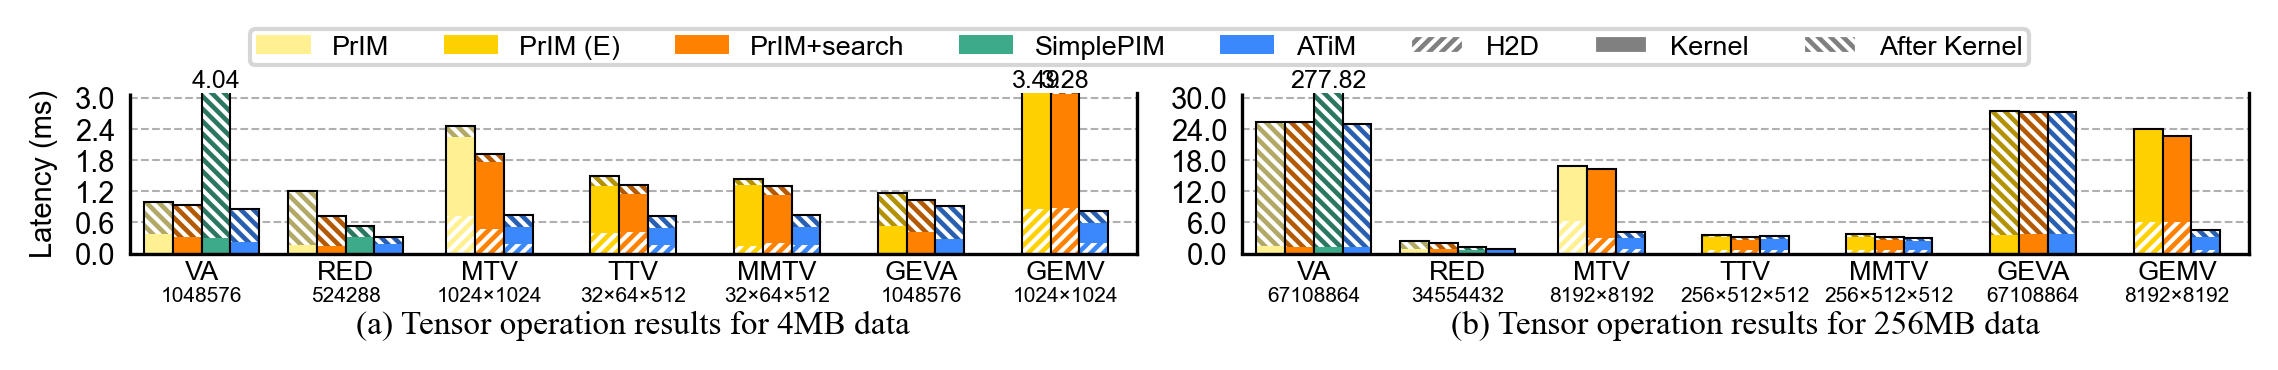

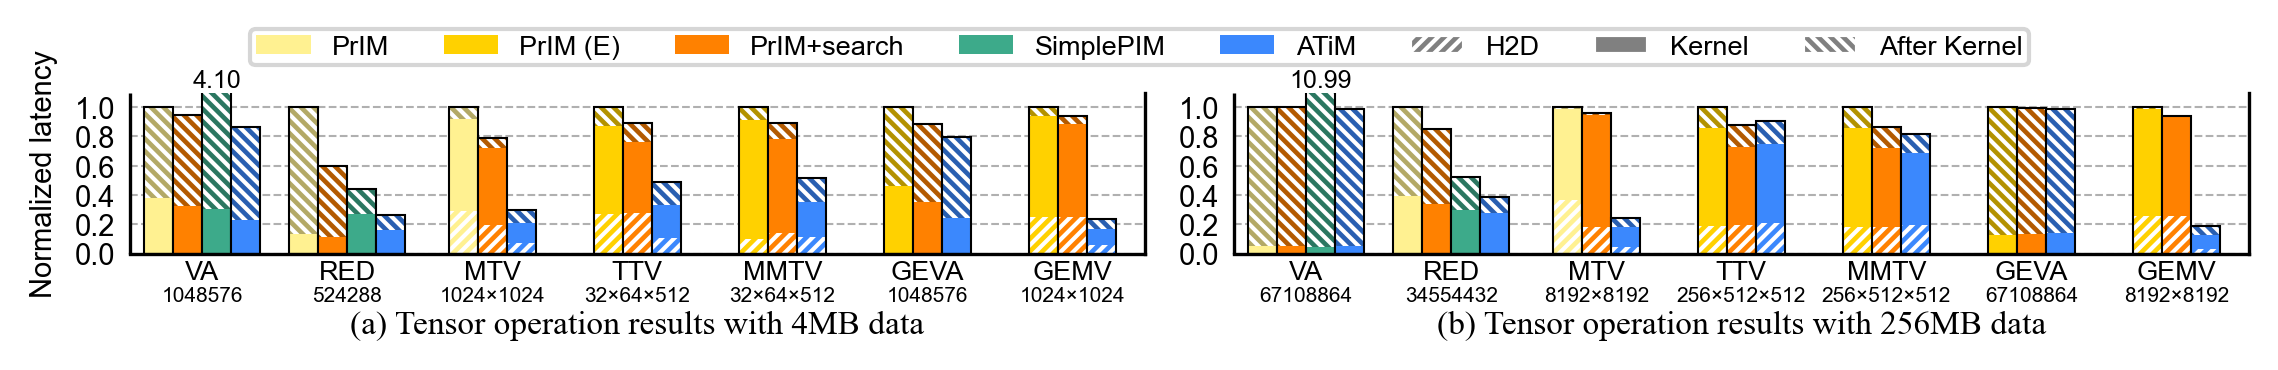

In [17]:
# polybench
from matplotlib.transforms import Affine2D

threshold = 3.2 # 상위 12행
interval = 0.5
width_polybench = 19 / 2
height = 2.5
height_table = 0.5
bar_width = 0.2
fontsize = 7
latency_label = "Latency (ms)"
normalize = False
show_pst = True



# Define a function to create the plot

def create_plot(ax, df_subset, width, threshold, interval=0.5, bar_width=0.25, colors=colors, hatches=hatches, caption="", batch_unit=16):
    x = np.arange(len(df_subset['Workload']))
    ax.set_xlim(-0.5, len(x) - 0.5)
    ax.set_ylim(0, threshold)
    ax.yaxis.grid(True, linestyle='--', zorder=0, linewidth=0.5)
    y_ticks = np.arange(0, threshold, interval)
    ax.tick_params(axis='both', which='both', direction='in', length=0)
    ax.set_yticks(y_ticks)
    ax.set_yticklabels([f"{tick:.1f}" for tick in y_ticks], fontsize=fontsize)
    ax.set_xticklabels([])
    ax.set_xticks(x)

    ax.spines['left'].set_capstyle("butt")
    ax.spines['left'].set_clip_on(False)
    ax.spines['top'].set_visible(False)


    def is_workload_prim(workload):
        wl = workload.split(" ")[0]
        return wl in ["va", "red", "mtv"]

    def is_workload_simplepim(workload):
        wl = workload.split(" ")[0]
        return wl in ["va", "red"]

    def plot_bars(ax, x, df, label_prefix, color, hatch):
        h2d_val = df[f'{label_prefix}-H2D'].astype(float)
        kernel_val = df[f'{label_prefix}-Kernel'].astype(float)
        after_val = df[f'{label_prefix}-After'].astype(float)
        pos = x
        ax.bar(pos, h2d_val, bar_width,
               linewidth=0, zorder=2,label=f'{label_prefix}-H2D',
               color=color, edgecolor="white", hatch=hatch['H2D'])
        ax.bar(pos, kernel_val, bar_width, bottom=h2d_val,
               linewidth=0, zorder=2, label=f'{label_prefix}-Kernel',
               color=color, hatch=hatch['Kernel'])
        adjusted_color = adjust_color(color)
        ax.bar(pos, after_val, bar_width, bottom=h2d_val + kernel_val,
               linewidth=0, zorder=2, label=f'{label_prefix}-After',
               color=adjusted_color, edgecolor="white", hatch=hatch['After'])
        ax.bar(pos, h2d_val + kernel_val + after_val, bar_width,
               linewidth=0.5, zorder=2, edgecolor='black', fill=False)
        total_height = (h2d_val + kernel_val + after_val).tolist()
        for i in range(len(x)):
            if total_height[i] > threshold:
                ax.text(x[i], threshold, f'{total_height[i]:.2f}', ha='center', va='bottom', fontsize=fontsize - 1)

    prim_colors = [colors["PrIM" if is_workload_prim(wl) else "PrIMC"] for wl in df_subset["Workload"].values]

    # if show_pst:
    #    bar_width = 0.2
    #    plot_bars(ax, x - bar_width, df_subset, 'PrIM', prim_colors, hatches)
    #    plot_bars(ax, x, df_subset, 'PS', colors['PS'], hatches)
    #    plot_bars(ax, x + bar_width, df_subset, 'ATiM', colors['ATiM'], hatches)
    # else:
    #    bar_width = 0.3
    #    plot_bars(ax, x - bar_width /2, df_subset, 'PrIM', prim_colors, hatches)
    #    plot_bars(ax, x + bar_width /2, df_subset, 'ATiM', colors['ATiM'], hatches)

    for i, workload in enumerate(df_subset['Workload']):
        if is_workload_simplepim(workload):
            # For VA and RED: 4 bars
            plot_bars(ax, [x[i] - 1.5 * bar_width], df_subset.iloc[[i]], 'PrIM', prim_colors[i], hatches)
            plot_bars(ax, [x[i] - 0.5 * bar_width], df_subset.iloc[[i]], 'PS', colors['PS'], hatches)
            plot_bars(ax, [x[i] + 0.5 * bar_width], df_subset.iloc[[i]], 'SimplePIM', colors['SimplePIM'], hatches)
            plot_bars(ax, [x[i] + 1.5 * bar_width], df_subset.iloc[[i]], 'ATiM', colors['ATiM'], hatches)
        else:
            # For other workloads: 3 bars
            plot_bars(ax, [x[i] - bar_width], df_subset.iloc[[i]], 'PrIM', prim_colors[i], hatches)
            plot_bars(ax, [x[i]], df_subset.iloc[[i]], 'PS', colors['PS'], hatches)
            plot_bars(ax, [x[i] + bar_width], df_subset.iloc[[i]], 'ATiM', colors['ATiM'], hatches)
    # TWO
    """
    va 67108864 1 1
    red 33554432 1 1
    mtv 8192 1 8192
    ttv 256 512 512
    mmtv 256 512 512
    polyva 67108864 1 1
    polygemv1 8192 1 8192
    va 1048576 1 1
    red 524288 1 1
    mtv 1024 1 1024
    ttv 32 64 512
    mmtv 32 64 512
    polyva 1048576 1 1
    polygemv1 1024 1 1024
    """
    workloads = df_subset['Workload'].str.split(' ', expand=True)
    W_labels = workloads[0]
    shapes = [
        ["67108864", "34554432", "8192×8192", "256×512×512", "256×512×512", "67108864", "8192×8192"],
        ["1048576", "524288", "1024×1024", "32×64×512", "32×64×512", "1048576", "1024×1024"]
    ]
    target_shape = shapes[0] if list(workloads[1])[0] == "67108864" else shapes[1]
    for i, label in enumerate(W_labels):
        l = label.upper()
        if l == "POLYGEMV1":
            l = "GEMV"
        elif l == "POLYVA":
            l = "GEVA"
        # __fontsize = 6 if l == "POLYGEMV1" else 6.5
        ax.text(x[i], -0.04, l, ha='center', va='top', transform=ax.get_xaxis_transform(), fontsize=6.5)
        ax.text(x[i], -0.2, target_shape[i], ha='center', va='top', transform=ax.get_xaxis_transform(), fontsize=5)

    # caption
    if caption:
        ax.text(0.5, -0.35, caption, ha='center', va='top',
                transform=ax.transAxes, fontsize=8, fontname='Times New Roman')

def add_fig(stem_name):
    fig = plt.figure(figsize=(7.48,  height / 2.54), dpi=300, constrained_layout=True)
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1], wspace=0.03, figure=fig)
    axs = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1])]


    if not normalize:
        create_plot(axs[0], df2.iloc[7:14], width_polybench, threshold=3.1, interval=0.6,
                    bar_width=bar_width, colors=colors, hatches=hatches, caption="(a) Tensor operation results for 4MB data",)
        axs[0].set_ylabel(latency_label, fontsize=fontsize)
        create_plot(axs[1], df2.iloc[:7], width_polybench, threshold=31, interval=6,
                    bar_width=bar_width, colors=colors, hatches=hatches, caption="(b) Tensor operation results for 256MB data")
    else:
        create_plot(axs[0], df4.iloc[7:14], width_polybench, threshold=1.1, interval=0.2,
                    bar_width=bar_width, colors=colors, hatches=hatches, caption="(a) Tensor operation results with 4MB data")
        axs[0].set_ylabel(latency_label, fontsize=fontsize)
        create_plot(axs[1], df4.iloc[0:7], width_polybench, threshold=1.1, interval=0.2,
                    bar_width=bar_width, colors=colors, hatches=hatches, caption="(b) Tensor operation results with 256MB data")

    # 기존 handles를 Rectangle로 수정하여 hatch를 추가
    handles = [
        Rectangle((0, 0), 1, 1, facecolor=colors["PrIM"], label='PrIM'),
        Rectangle((0, 0), 1, 1, facecolor=colors["PrIMC"], label='PrIM (E)'),
        Rectangle((0, 0), 1, 1, facecolor=colors["PS"], label='PrIM+search'),
        Rectangle((0, 0), 1, 1, facecolor=colors["SimplePIM"], label="SimplePIM"),
        Rectangle((0, 0), 1, 1, facecolor=colors["ATiM"], label='ATiM'),
        Rectangle((0, 0), 1, 1, facecolor='gray', label='H2D', edgecolor="white",hatch=hatches["H2D"]),
        Rectangle((0, 0), 1, 1, facecolor='gray', label='Kernel', edgecolor="white"),
        Rectangle((0, 0), 1, 1, facecolor='gray', label='After Kernel', edgecolor="white",hatch=hatches["After"])
    ]

    # 범례 추
    fig.legend(handles=handles, loc='upper center', ncol=8, fontsize=fontsize - 0.5, bbox_to_anchor=(0.5, 1.14), borderpad=0.22,)
    # fig.savefig(f"poly.pdf", format="pdf", dpi=300, bbox_inches="tight")
    fig.savefig(f"/Users/kdk/Library/CloudStorage/OneDrive-SNU/ATiM Eurosys2025/{stem_name}.pdf", format="pdf", dpi=300, bbox_inches="tight")

latency_label = "Latency (ms)"

normalize = False
add_fig("polybench_experiment")
latency_label = "Normalized latency"
normalize = True
add_fig("polybench_experiment_normalized")

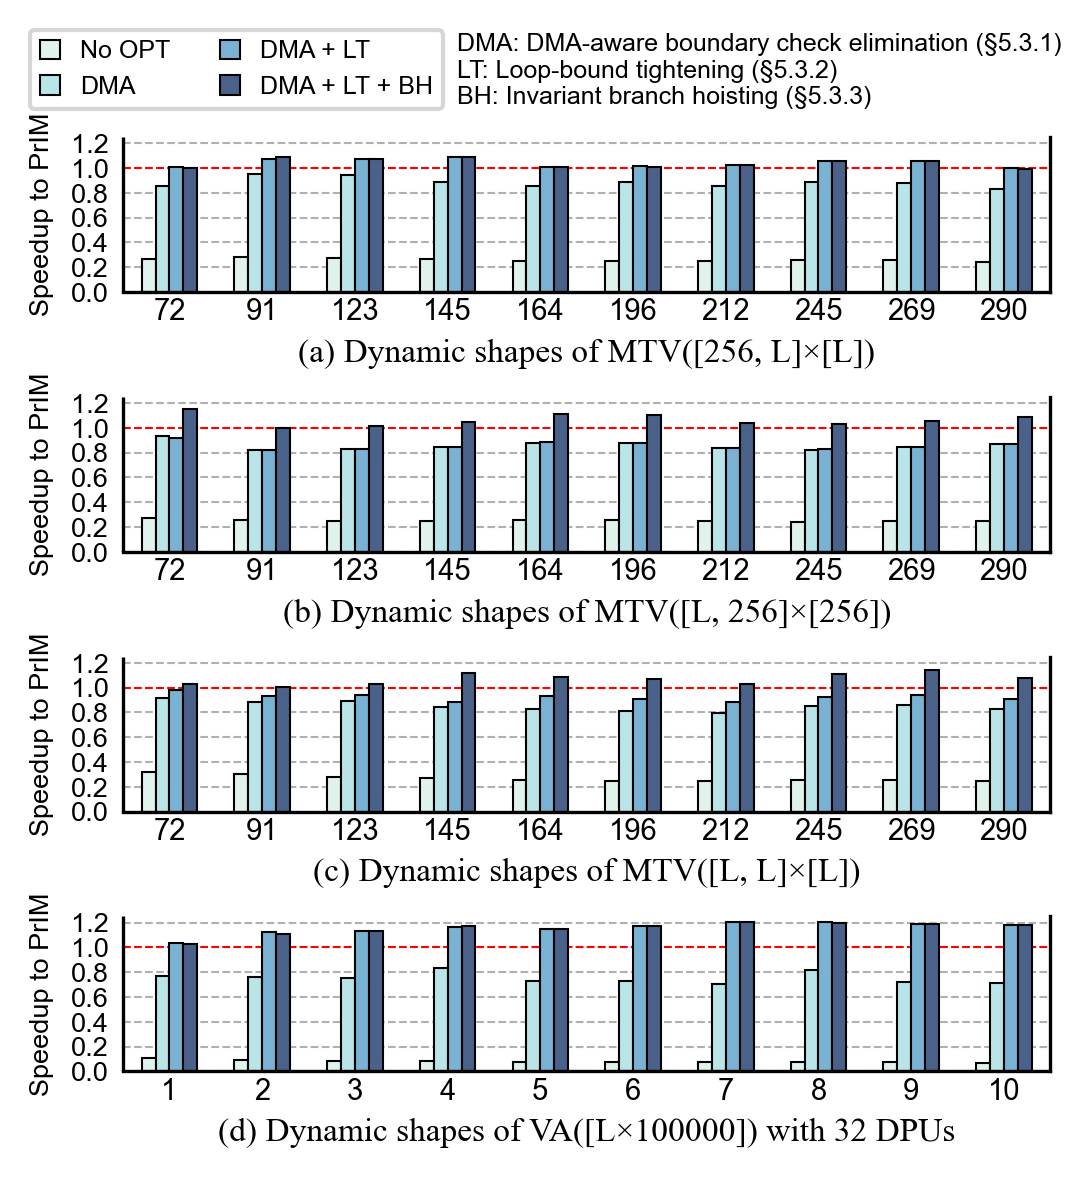

In [ ]:
# polybench

threshold = 3.2 # 상위 12행
interval = 0.5
width_polybench = 19 / 2
height = 2.2
height_table = 0.5
bar_width = 0.2
fontsize = 7
latency_label = "Latency (ms)"
normalize = False
show_pst = False

sens_cols = {
    "O0": "#dff2eb",
    "O1": "#b9e5e8",
    "O2": "#7ab2d3",
    "O4": "#4a628a",
}

# Define a function to create the plot
def create_plot(ax, df_subset, width, threshold, interval=0.5, bar_width=0.25, colors=colors, hatches=hatches, caption="", batch_unit=16):
    x = np.arange(len(df_subset['M']), dtype=int)
    ax.set_xlim(-0.5, len(x) - 0.5)
    ax.set_ylim(0, threshold)
    ax.yaxis.grid(True, linestyle='--', zorder=0, linewidth=0.5)
    y_ticks = np.arange(0, threshold, interval)
    ax.tick_params(axis='both', which='both', direction='in', length=0)
    ax.set_yticks(y_ticks)
    ax.set_yticklabels([f"{tick:.1f}" for tick in y_ticks], fontsize=fontsize-0.5)
    ax.set_xticklabels([])
    ax.set_xticks(x)

    # Add a red dashed line at y=1.0 to indicate PrIM
    ax.axhline(y=1.0, color='red', linestyle='--', linewidth=0.5)

    ax.spines['left'].set_capstyle("butt")
    ax.spines['left'].set_clip_on(False)
    ax.spines['top'].set_visible(False)

    bar_width = 0.15

    # ax.bar(x - bar_width / 2, df_subset["PrIM"], bar_width,
    #     linewidth=0, zorder=2, color=colors["PrIM"])
    bars = [
        ax.bar(x - bar_width * 3 / 2, df_subset["PrIM"] / df_subset["O0"], bar_width,
               linewidth=0.5, zorder=2, color=sens_cols["O0"], edgecolor="black", label="No OPT"),
        ax.bar(x - bar_width / 2, df_subset["PrIM"] / df_subset["O1"], bar_width,
               linewidth=0.5, zorder=2, color=sens_cols["O1"], edgecolor="black", label="DMA"),
        ax.bar(x + bar_width / 2, df_subset["PrIM"] / df_subset["O2"], bar_width,
               linewidth=0.5, zorder=2, color=sens_cols["O2"], edgecolor="black", label="DMA + LT"),
        ax.bar(x + bar_width * 3 / 2, df_subset["PrIM"] / df_subset["O4"], bar_width,
               linewidth=0.5, zorder=2, color=sens_cols["O4"], edgecolor="black", label="DMA + LT + BH")
    ]

    # Add actual values as small labels above the bars
    for bar_group in bars:
        for bar in bar_group:
            height = bar.get_height()
            if height > threshold:
                ax.annotate(f'{height:.2f}',
                            xy=(bar.get_x() + bar.get_width() / 2, threshold),
                            xytext=(0, 1),  # 3 points vertical offset
                            textcoords="offset points",
                            ha='center', va='bottom', fontsize=6)

    # TWO
    workloads = df_subset['M'].astype("int")
    for i, label in enumerate(workloads):
        ax.text(x[i], -0.04, label, ha='center', va='top', transform=ax.get_xaxis_transform(), fontsize=7)
    # caption
    if caption:
        ax.text(0.5, -0.3, caption, ha='center', va='top',
                transform=ax.transAxes, fontsize=8, fontname='Times New Roman')
    ax.set_ylabel(latency_label, fontsize=fontsize - 0.5)


def add_fig_mmtv(stem_name):
    fig = plt.figure(figsize=(8.85 / 2.54,  height / 2.54 * 2), dpi=300, constrained_layout=True)
    gs = gridspec.GridSpec(2, 1,height_ratios=[1, 1], hspace=0.03, figure=fig)
    axs = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[1, 0])]

    create_plot(axs[0], df_opt.iloc[0:8], width_polybench, threshold=1.4, interval=0.2,
                bar_width=bar_width, colors=colors, hatches=hatches, caption="(a) Dynamic shapes of MMTV([64, T, 256]×[64, 256])")
    axs[0].set_ylabel(latency_label, fontsize=fontsize - 0.5)
    create_plot(axs[1], df_opt.iloc[8:16], width_polybench, threshold=1.4, interval=0.2,
                bar_width=bar_width, colors=colors, hatches=hatches, caption="(b) Dynamic shapes of MMTV([64, T, T×[64, T])")
    axs[1].set_ylabel(latency_label, fontsize=fontsize - 0.5)

    # Add legend from axs[0] to the top of the figure
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=4, fontsize=fontsize, bbox_to_anchor=(0.5, 1.15))
    #fig.legend(handles, labels, loc='upper center', fontsize=fontsize, bbox_to_anchor=(0.5, 1.1))
    fig.savefig(f"/Users/kdk/Library/CloudStorage/OneDrive-SNU/ATiM Eurosys2025/{stem_name}.pdf", format="pdf", dpi=300, bbox_inches="tight")

def add_fig_mtv(stem_name):
    fig = plt.figure(figsize=(8.85 / 2.54,  height / 2.54 * 4), dpi=300, constrained_layout=True)
    gs = gridspec.GridSpec(4, 1,height_ratios=[1, 1, 1, 1], hspace=0.03, figure=fig)
    axs = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[1, 0]), fig.add_subplot(gs[2, 0]), fig.add_subplot(gs[3, 0])]
    create_plot(axs[0], df_opt.iloc[57:67], width_polybench, threshold=1.25, interval=0.2,
                bar_width=bar_width, colors=colors, hatches=hatches, caption="(a) Dynamic shapes of MTV([256, L]×[L])")
    create_plot(axs[1], df_opt.iloc[67:77], width_polybench, threshold=1.25, interval=0.2,
                bar_width=bar_width, colors=colors, hatches=hatches, caption="(b) Dynamic shapes of MTV([L, 256]×[256])")
    create_plot(axs[2], df_opt.iloc[77:87], width_polybench, threshold=1.25, interval=0.2,
                bar_width=bar_width, colors=colors, hatches=hatches, caption="(c) Dynamic shapes of MTV([L, L]×[L])")
    create_plot(axs[3], df_opt.iloc[87:97], width_polybench, threshold=1.25, interval=0.2,
                bar_width=bar_width, colors=colors, hatches=hatches, caption="(d) Dynamic shapes of VA([L×100000]) with 32 DPUs")
    # Add legend from axs[0] to the top of the figure
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper left', ncol=2, fontsize=fontsize - 1, bbox_to_anchor=(0.0, 1.1), handlelength=0.8, handleheight=0.8)

    fig.text(0.42, 1.085, "DMA: DMA-aware boundary check elimination (§5.3.1)\nLT: Loop-bound tightening (§5.3.2)\nBH: Invariant branch hoisting (§5.3.3)", ha='left', va='top', fontsize=fontsize - 1, transform=fig.transFigure)
    #fig.legend(handles, labels, loc='upper center', fontsize=fontsize, bbox_to_anchor=(0.5, 1.1))
    fig.savefig(f"/Users/kdk/Library/CloudStorage/OneDrive-SNU/ATiM Eurosys2025/{stem_name}.pdf", format="pdf", dpi=300, bbox_inches="tight")

latency_label = "Speedup to PrIM"
normalize = True
# df4.iloc[:, 2:] = df4.iloc[:, 2:].astype(float).div(df4.iloc[:, 2:5].astype(float).sum(axis=1), axis=0)
add_fig_mtv("opt_experiment_mtv_normalized")

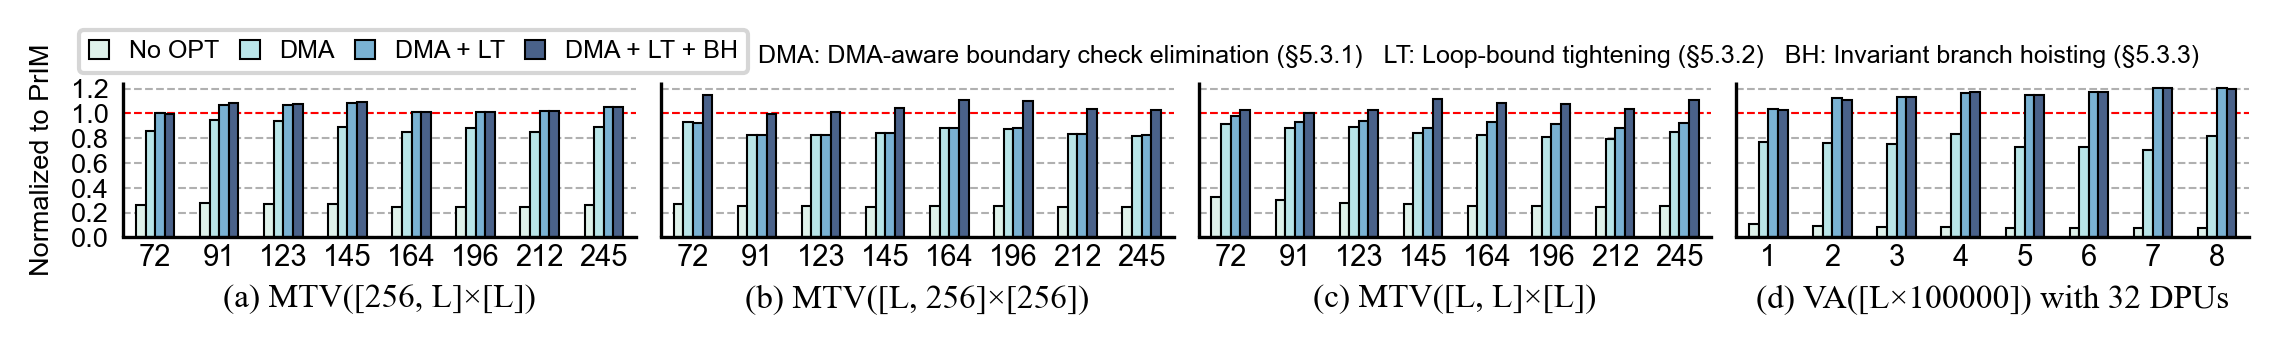

In [ ]:
# polybench

threshold = 3.2 # 상위 12행
interval = 0.5
width_polybench = 19 / 2
height = 2.2
height_table = 0.5
bar_width = 0.2
fontsize = 7
latency_label = "Latency (ms)"
normalize = False
show_pst = False

sens_cols = {
    "O0": "#dff2eb",
    "O1": "#b9e5e8",
    "O2": "#7ab2d3",
    "O4": "#4a628a",
}

# Define a function to create the plot
def create_plot(ax, df_subset, width, threshold, interval=0.5, bar_width=0.25, colors=colors, hatches=hatches, caption="", batch_unit=16):
    x = np.arange(len(df_subset['M']), dtype=int)
    ax.set_xlim(-0.5, len(x) - 0.5)
    ax.set_ylim(0, threshold)
    ax.yaxis.grid(True, linestyle='--', zorder=0, linewidth=0.5)
    y_ticks = np.arange(0, threshold, interval)
    ax.tick_params(axis='both', which='both', direction='in', length=0)
    ax.set_yticks(y_ticks)
    ax.set_yticklabels([f"{tick:.1f}" for tick in y_ticks], fontsize=fontsize-0.5)
    ax.set_xticklabels([])
    ax.set_xticks(x)

    # Add a red dashed line at y=1.0 to indicate PrIM
    ax.axhline(y=1.0, color='red', linestyle='--', linewidth=0.5)

    ax.spines['left'].set_capstyle("butt")
    ax.spines['left'].set_clip_on(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    bar_width = 0.15

    # ax.bar(x - bar_width / 2, df_subset["PrIM"], bar_width,
    #     linewidth=0, zorder=2, color=colors["PrIM"])
    bars = [
        ax.bar(x - bar_width * 3 / 2, df_subset["PrIM"] / df_subset["O0"], bar_width,
               linewidth=0.5, zorder=2, color=sens_cols["O0"], edgecolor="black", label="No OPT"),
        ax.bar(x - bar_width / 2, df_subset["PrIM"] / df_subset["O1"], bar_width,
               linewidth=0.5, zorder=2, color=sens_cols["O1"], edgecolor="black", label="DMA"),
        ax.bar(x + bar_width / 2, df_subset["PrIM"] / df_subset["O2"], bar_width,
               linewidth=0.5, zorder=2, color=sens_cols["O2"], edgecolor="black", label="DMA + LT"),
        ax.bar(x + bar_width * 3 / 2, df_subset["PrIM"] / df_subset["O4"], bar_width,
               linewidth=0.5, zorder=2, color=sens_cols["O4"], edgecolor="black", label="DMA + LT + BH")
    ]

    # Add actual values as small labels above the bars
    for bar_group in bars:
        for bar in bar_group:
            height = bar.get_height()
            if height > threshold:
                ax.annotate(f'{height:.2f}',
                            xy=(bar.get_x() + bar.get_width() / 2, threshold),
                            xytext=(0, 1),  # 3 points vertical offset
                            textcoords="offset points",
                            ha='center', va='bottom', fontsize=6)

    # TWO
    workloads = df_subset['M'].astype("int")
    for i, label in enumerate(workloads):
        ax.text(x[i], -0.04, label, ha='center', va='top', transform=ax.get_xaxis_transform(), fontsize=7)
    # caption
    if caption:
        ax.text(0.5, -0.3, caption, ha='center', va='top',
                transform=ax.transAxes, fontsize=8, fontname='Times New Roman')



def add_fig_mmtv(stem_name):
    fig = plt.figure(figsize=(8.85 / 2.54,  height / 2.54 + 0.1), dpi=300, constrained_layout=True)
    gs = gridspec.GridSpec(2, 1,height_ratios=[1, 1], hspace=0.03, figure=fig)
    axs = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[1, 0])]

    create_plot(axs[0], df_opt.iloc[0:8], width_polybench, threshold=1.4, interval=0.2,
                bar_width=bar_width, colors=colors, hatches=hatches, caption="(a) Dynamic shapes of MMTV([64, T, 256]×[64, 256])")
    axs[0].set_ylabel(latency_label, fontsize=fontsize - 0.5)
    create_plot(axs[1], df_opt.iloc[8:16], width_polybench, threshold=1.4, interval=0.2,
                bar_width=bar_width, colors=colors, hatches=hatches, caption="(b) Dynamic shapes of MMTV([64, T, T×[64, T])")
    axs[1].set_ylabel(latency_label, fontsize=fontsize - 0.5)

    # Add legend from axs[0] to the top of the figure
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=4, fontsize=fontsize, bbox_to_anchor=(0.5, 1.15))
    #fig.legend(handles, labels, loc='upper center', fontsize=fontsize, bbox_to_anchor=(0.5, 1.1))
    fig.savefig(f"/Users/kdk/Library/CloudStorage/OneDrive-SNU/ATiM Eurosys2025/{stem_name}.pdf", format="pdf", dpi=300, bbox_inches="tight")

def add_fig_mtv(stem_name):
    width_4 = 4.2
    fig = plt.figure(figsize=(19 / 2.54,  height / 2.54), dpi=300, constrained_layout=True)
    gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1, 1], wspace=0.0, figure=fig)
    axs = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1]), fig.add_subplot(gs[0, 2]), fig.add_subplot(gs[0, 3])]
    create_plot(axs[0], df_opt.iloc[57:65], width_4, threshold=1.25, interval=0.2,
                bar_width=bar_width, colors=colors, hatches=hatches, caption="(a) MTV([256, L]×[L])")
    axs[0].set_ylabel(latency_label, fontsize=fontsize - 0.5)
    create_plot(axs[1], df_opt.iloc[67:75], width_4, threshold=1.25, interval=0.2,
                bar_width=bar_width, colors=colors, hatches=hatches, caption="(b) MTV([L, 256]×[256])")
    axs[1].tick_params(axis='y', labelleft=False)
    create_plot(axs[2], df_opt.iloc[77:85], width_4, threshold=1.25, interval=0.2,
                bar_width=bar_width, colors=colors, hatches=hatches, caption="(c) MTV([L, L]×[L])")
    axs[2].tick_params(axis='y', labelleft=False)
    create_plot(axs[3], df_opt.iloc[87:95], width_4, threshold=1.25, interval=0.2,
                bar_width=bar_width, colors=colors, hatches=hatches, caption="(d) VA([L×100000]) with 32 DPUs")
    axs[3].tick_params(axis='y', labelleft=False)
    # Add legend from axs[0] to the top of the figure
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper left', ncol=4, fontsize=fontsize - 1, bbox_to_anchor=(0.022,  1.19), columnspacing=0.8, handlelength=0.8, handleheight=0.8)
    fig.text(0.33, 1.085, "DMA: DMA-aware boundary check elimination (§5.3.1)   LT: Loop-bound tightening (§5.3.2)   BH: Invariant branch hoisting (§5.3.3)", ha='left', va='top', fontsize=fontsize - 1, transform=fig.transFigure)
    #fig.legend(handles, labels, loc='upper center', fontsize=fontsize, bbox_to_anchor=(0.5, 1.1))
    fig.savefig(f"/Users/kdk/Library/CloudStorage/OneDrive-SNU/ATiM Eurosys2025/{stem_name}.pdf", format="pdf", dpi=300, bbox_inches="tight")

latency_label = "Normalized to PrIM"
normalize = True
# df4.iloc[:, 2:] = df4.iloc[:, 2:].astype(float).div(df4.iloc[:, 2:5].astype(float).sum(axis=1), axis=0)
add_fig_mtv("opt_experiment_mtv_normalized")